# Waste Level Prediction

In [1]:
import boto3
from sagemaker import get_execution_role
role  = get_execution_role()


## Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'Data_Set_project.csv'
data = pd.read_csv(file_path)

# Display the first few rows
data.head()

,id,Fill Percentage,battery,eventDate,Distance
0,5c2bf397530484f84463,70,56,2022-09-25T12:06:41.265Z,798
1,5c2bf397530484f84463,70,56,2022-09-25T12:11:42.497Z,800
2,5c2bf397530484f84463,69,56,2022-09-25T12:16:43.875Z,804
3,5c2bf397530484f84463,79,56,2022-09-25T12:21:45.116Z,613
4,5c2bf397530484f84463,70,56,2022-09-25T12:26:46.436Z,792


In [3]:
# Convert 'eventDate' to datetime format
data['eventDate'] = pd.to_datetime(data['eventDate'])

# Rounding 'eventDate' to the nearest 5-minute interval
data['eventDate'] = data['eventDate'].dt.round(freq='5min')

# Setting 'eventDate' as the index
data.set_index('eventDate', inplace=True)

# Displaying the first few rows after rounding to the nearest 5-minute interval
data.head()


,id,Fill Percentage,battery,Distance
eventDate,,,,
2022-09-25 12:05:00+00:00,5c2bf397530484f84463,70,56,798
2022-09-25 12:10:00+00:00,5c2bf397530484f84463,70,56,800
2022-09-25 12:15:00+00:00,5c2bf397530484f84463,69,56,804
2022-09-25 12:20:00+00:00,5c2bf397530484f84463,79,56,613
2022-09-25 12:25:00+00:00,5c2bf397530484f84463,70,56,792


In [4]:

# Check the data types
data.dtypes

id                 object
Fill Percentage     int64
battery             int64
Distance            int64
dtype: object

In [5]:
# Displaying summary statistics for the numerical columns
summary_statistics = data.describe()
summary_statistics

,Fill Percentage,battery,Distance
count,16801.000000,16801.000000,16801.000000
mean,49.323552,55.482947,1255.906613
std,28.042900,1.137702,666.858032
min,0.000000,52.000000,300.000000
25%,33.000000,56.000000,808.000000
50%,55.000000,56.000000,1085.000000
75%,69.000000,56.000000,1525.000000
max,95.000000,56.000000,3001.000000


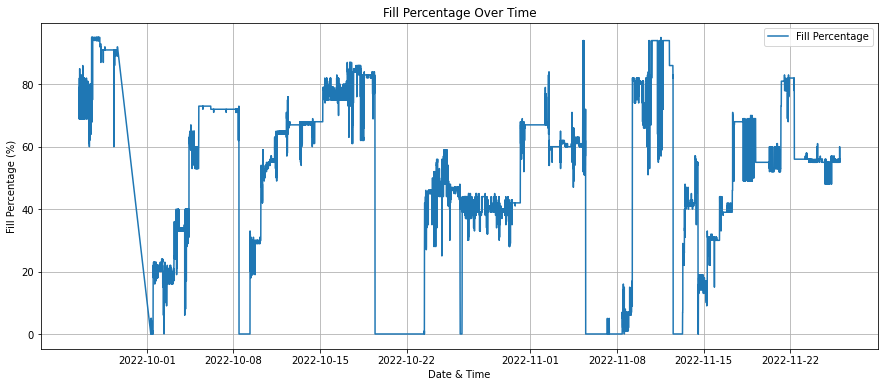

In [6]:
# Importing required libraries for visualization
import matplotlib.pyplot as plt

# Plotting "Fill Percentage" over time
plt.figure(figsize=(15, 6))
plt.plot(data['Fill Percentage'], label="Fill Percentage")
plt.title('Fill Percentage Over Time')
plt.xlabel('Date & Time')
plt.ylabel('Fill Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


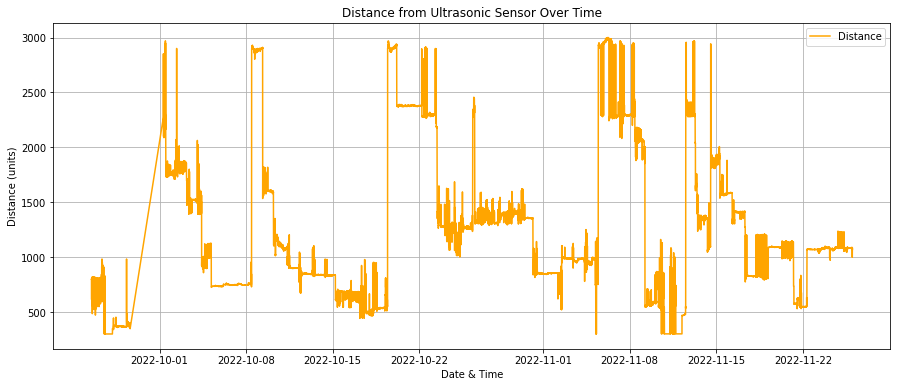

In [7]:
# Plotting "Distance" over time
plt.figure(figsize=(15, 6))
plt.plot(data['Distance'], label="Distance", color='orange')
plt.title('Distance from Ultrasonic Sensor Over Time')
plt.xlabel('Date & Time')
plt.ylabel('Distance (units)')
plt.legend()
plt.grid(True)
plt.show()


### Missing data

In [8]:
# Import necessary libraries
import pandas as pd

# Filter the data to include only timestamps from October 2022 onwards
data_filtered = data.loc['2022-10-01':]

# Resample the data at 5-minute intervals and identify any missing timestamps
resampled_data = data_filtered['Fill Percentage'].resample('5T').asfreq()

# Find the missing timestamps (if any)
missing_timestamps = resampled_data[resampled_data.isnull()].index

# Check if there are any missing timestamps by verifying the length of missing_timestamps
has_missing_timestamps = len(missing_timestamps) > 0

# Summary of missing timestamps
missing_summary = {
    'Number of Missing Timestamps': len(missing_timestamps),
    'First Missing Timestamp': missing_timestamps.min() if has_missing_timestamps else None,
    'Last Missing Timestamp': missing_timestamps.max() if has_missing_timestamps  else None
}

missing_summary


{'Number of Missing Timestamps': 133,
 'First Missing Timestamp': Timestamp('2022-10-01 12:10:00+0000', tz='UTC'),
 'Last Missing Timestamp': Timestamp('2022-11-25 23:50:00+0000', tz='UTC')}



#### Analyzing Time to Fill the Dustbin


1. Identify periods where the fill percentage reaches or exceeds a certain threshold (e.g., 90% or 100%).
2. Calculate the time it takes to reach this threshold from a lower fill percentage (20%).
3. Provide a summary of the fill times, including average, minimum, and maximum durations.


In [9]:
# Interpolating the missing values in the filtered data (only for the analysis purpose)
data_filtered_interpolated = data_filtered.interpolate(method='time')

# Identify timestamps where the fill percentage drops below 20%
below_20_indices = data_filtered_interpolated[data_filtered_interpolated['Fill Percentage'] < 20].index

# Identify timestamps where the fill percentage reaches or exceeds 90%
capacity_90_timestamps = data_filtered_interpolated[data_filtered_interpolated['Fill Percentage'] >= 90].index

# Initialize variables to store the start and end times of the fill periods
start_times_20 = []
end_times_20 = []

# Iterate through the below-20% timestamps and identify the corresponding 90% fill periods
for idx in range(1, len(below_20_indices)):
    start_time = below_20_indices[idx - 1]
    end_time = below_20_indices[idx]
    
    # Check if there is a 90% capacity timestamp between the start and end times
    fill_period = capacity_90_timestamps[(capacity_90_timestamps > start_time) & (capacity_90_timestamps < end_time)]
    if len(fill_period) > 0:
        start_times_20.append(start_time)
        end_times_20.append(fill_period[0])

# Calculate the time intervals to reach 90% capacity for the identified periods
time_to_fill_90_intervals_20_revised = [end - start for start, end in zip(start_times_20, end_times_20)]

# Convert the time intervals to a pandas Series for easy statistical analysis
time_to_fill_90_intervals_20_series = pd.Series(time_to_fill_90_intervals_20_revised)

# Summary of time intervals to reach 90% capacity (revised analysis with 20% threshold)
time_to_fill_90_summary_20_revised = {
    'Number of 90% Capacity Periods': len(time_to_fill_90_intervals_20_series),
    'Average Time to Fill to 90%': time_to_fill_90_intervals_20_series.mean(),
    'Minimum Time to Fill to 90%': time_to_fill_90_intervals_20_series.min(),
    'Maximum Time to Fill to 90%': time_to_fill_90_intervals_20_series.max()
}

time_to_fill_90_summary_20_revised




{'Number of 90% Capacity Periods': 2,
 'Average Time to Fill to 90%': Timedelta('5 days 13:22:30'),
 'Minimum Time to Fill to 90%': Timedelta('1 days 08:05:00'),
 'Maximum Time to Fill to 90%': Timedelta('9 days 18:40:00')}



##### Test Set Definition Based on Fill Cycle Analysis

Through an in-depth analysis of the time it takes for the dustbin to fill to 90% capacity, we identified distinct fill cycles by considering readings below 20% as the starting point for each cycle. This approach ensures that we capture the time required to fill the dustbin from a nearly empty state to 90% full.

The analysis revealed the following insights:
- **Average Time to Fill to 90%**: Approximately 5 days, 13 hours, 22 minutes
- **Minimum Time to Fill to 90%**: Approximately 1 day, 8 hours, 3 minutes
- **Maximum Time to Fill to 90%**: Approximately 9 days, 18 hours, 41 minutes

Given this information, we can define the test set length as 5 days, representing a typical fill cycle. This choice balances the need to capture the inherent variability in fill times with the desire to have a test set that is representative of common scenarios.

By using a 5-day test set, we ensure that the model evaluation is grounded in the actual operational dynamics of the waste collection system, providing more robust and meaningful performance metrics.


### Data Preprocessing

In [10]:
# Define the test set length as 5 days
test_set_length = pd.Timedelta(days=5)

# Determine the timestamp to split the training and test sets
split_timestamp = data.index[-1] - test_set_length

# Split the data into training and test sets based on the determined timestamp
train_data = data_filtered_interpolated[data_filtered_interpolated.index <= split_timestamp]
test_data = data_filtered_interpolated[data_filtered_interpolated.index > split_timestamp]

# Interpolating the missing values in the training data
train_data = train_data.interpolate(method='time')

# Summary of the training and test set sizes
train_size = len(train_data)
test_size = len(test_data)

train_size, test_size


(14477, 1430)

In [11]:
# Extracting time-based features
train_data['hour'] = train_data.index.hour
train_data['day_of_week'] = train_data.index.dayofweek
train_data['is_weekend'] = train_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Extracting time-based features
test_data['hour'] = test_data.index.hour
test_data['day_of_week'] = test_data.index.dayofweek
test_data['is_weekend'] = test_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Displaying the first few rows after adding time-based features
train_data.head()

<ipython-input-11-8f7453d47a1c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['hour'] = test_data.index.hour
<ipython-input-11-8f7453d47a1c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['day_of_week'] = test_data.index.dayofweek
<ipython-input-11-8f7453d47a1c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,id,Fill Percentage,battery,Distance,hour,day_of_week,is_weekend
eventDate,,,,,,,
2022-10-01 07:25:00+00:00,5c2bf397530484f84463,0,56,2273,7,5,1
2022-10-01 07:30:00+00:00,5c2bf397530484f84463,0,56,2274,7,5,1
2022-10-01 07:35:00+00:00,5c2bf397530484f84463,0,56,2852,7,5,1
2022-10-01 07:40:00+00:00,5c2bf397530484f84463,4,56,2109,7,5,1
2022-10-01 07:45:00+00:00,5c2bf397530484f84463,4,56,2107,7,5,1


In [12]:
# Separating features (X) and target variable (y) for both training and testing sets
X_train = train_data.drop(columns=['Fill Percentage'])
y_train = train_data['Fill Percentage']
X_test = test_data.drop(columns=['Fill Percentage'])
y_test = test_data['Fill Percentage']

# Displaying the shape of the feature and target sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14477, 6), (14477,), (1430, 6), (1430,))

#### Conclusion of Data Exploration & Preprocessing

1. **Dataset Structure**: The dataset consists of readings from a sensor placed on a dustbin, capturing the "Fill Percentage," "Battery Level," and "Distance" from the ultrasonic sensor to the garbage.

2. **Preprocessing**: The timestamps were rounded to the nearest 5-minute interval, and irrelevant columns were removed. We treated missing values with interpolation.

3. **Summary Statistics**:
- **Fill Percentage**: Varied between 0% and 95%, with an average fill level of 49.32%.
. **Battery**: Mostly stable around the value of 56.
- **Distance**: Ranged from 300 to 3001 units, with an average distance of 1255.91 units.

4. **Visualizations**:
- **Fill Percentage**: The plot showed fluctuations and patterns, reflecting the usage and emptying cycles of the dustbin.
- **Distance**: The distance from the sensor varied inversely with the fill percentage, decreasing as the bin filled up.

### Seasonal Decomposition & Time Series Analysis

In [13]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


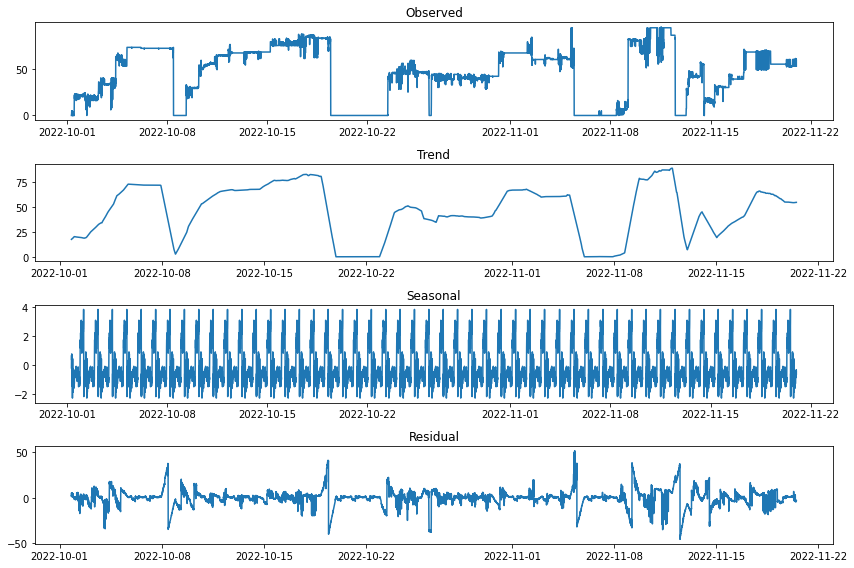

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Performing seasonal decomposition with daily seasonality (288 readings per day)
decomposition = seasonal_decompose(train_data['Fill Percentage'], period=288)

# Plotting the seasonal decomposition
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual')
plt.tight_layout()
plt.show()



The seasonal decomposition plot provides insights into different components of the "Fill Percentage" time series:

1. **Observed**: The original time series data, showing the fill percentage over time.
2. **Trend**: The underlying trend in the data, capturing long-term changes and general direction.
3. **Seasonal**: The repeating patterns that occur at regular intervals (in this case, daily). This plot reveals the daily seasonality in the fill percentage.
4. **Residual**: The remaining noise or random fluctuations after removing the trend and seasonal components.

The decomposition confirms the presence of daily seasonality in the data and provides a clearer view of the trend and residual components.

#### Conclusion of Seasonal Decomposition & Time Series Analysis

- **Daily Seasonality**: The decomposition revealed clear daily patterns in the fill percentage, which may correspond to usage cycles of the dustbin.
- **Trend Analysis**: The trend component can provide insights into the long-term changes or growth in waste levels.
- **Residual Analysis**: Understanding the residual component can help in modeling the unexplained variations and noise in the data.


##  Model Selection & Training 

### Models selection

For this project, we will focus on comparing this 4 models:

1. **SARIMA**: A seasonal autoregressive integrated moving average model, suitable for time series with seasonality.
2. **XGBoost**: A powerful gradient boosting algorithm that can model non-linear relationships.
3. **Prophet**: Designed for forecasting with daily observations, handling missing data, and seasonal effects.
4. **Holt-Winters Exponential Smoothing**: A smoothing method for time series forecasting, especially when data has clear trends and seasonality.


### Sarima



#### SARIMA (Seasonal AutoRegressive Integrated Moving Average)

SARIMA is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. It adds three new hyperparameters to specify the autoregression (AR), differencing (I), and moving average (MA) for the seasonal component of the series.

The hyperparameters of the SARIMA model are:
- \( p \): Trend autoregression order.
- \( d \): Trend difference order.
- \( q \): Trend moving average order.
- \( P \): Seasonal autoregressive order.
- \( D \): Seasonal difference order.
- \( Q \): Seasonal moving average order.
- \( m \): The number of time steps for a single seasonal period.

Given that we have daily seasonality with 5-minute intervals, \( m \) will be 288 (as there are 288 intervals in a day).

We will use auto_arima to find the best hyperparameters for this model.



#### Hyper parameter analysis


1. **ACF and PACF Plots**: These plots will help us understand the autocorrelation structure of the data and provide insights into the seasonal autoregressive (P) and moving average (Q) orders.
2. **ADF Test for Seasonal Differencing**: We'll perform the Augmented Dickey-Fuller (ADF) test on the seasonally differenced data to determine the order of seasonal differencing (D). This will help us identify if the seasonally differenced data is stationary.



#### 1. ACF and PACF Plots


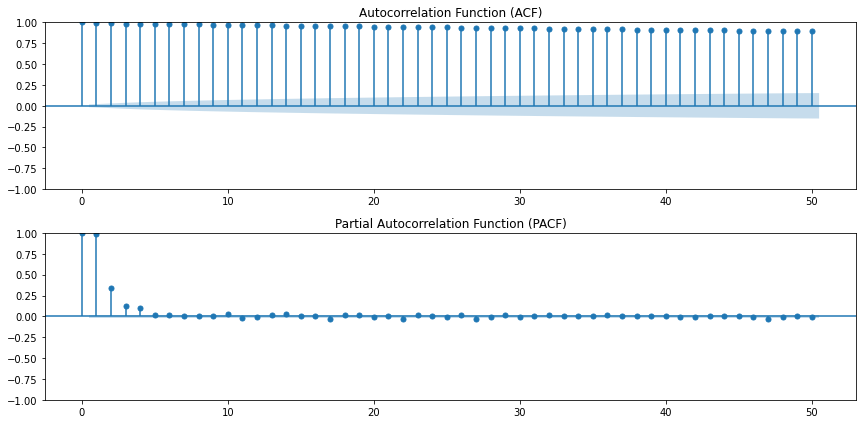

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting ACF (Autocorrelation Function)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(y_train, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# Plotting PACF (Partial Autocorrelation Function)
plt.subplot(2, 1, 2)
plot_pacf(y_train, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()



##### Insights:
- **Seasonal Lags**: We can observe spikes at regular intervals, suggesting the presence of daily seasonality.
- **P and Q Values**: Based on the PACF and ACF plots, we may consider trying different values for the seasonal autoregressive (P) and moving average (Q) terms during the model fitting process.


#### 2. Augmented Dickey-Fuller (ADF) Test

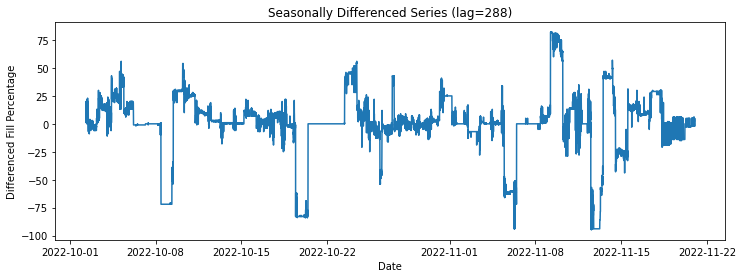

(-5.562741236592973, 1.528717069987429e-06)

In [16]:
# Importing adfuller function for ADF test
from statsmodels.tsa.stattools import adfuller

# Applying seasonal differencing with lag 288 (daily seasonality)
seasonal_diff = y_train.diff(288).dropna()

# Plotting the seasonally differenced series
plt.figure(figsize=(12, 4))
plt.plot(seasonal_diff)
plt.title('Seasonally Differenced Series (lag=288)')
plt.xlabel('Date')
plt.ylabel('Differenced Fill Percentage')
plt.show()

# Performing the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(seasonal_diff)
adf_statistic, adf_p_value = adf_result[0], adf_result[1]

adf_statistic, adf_p_value




##### Augmented Dickey-Fuller (ADF) Test Result

The ADF test is used to check for stationarity in a time series. Here are the results:

- **ADF Statistic**: \(-5.56\)
- **P-value**: \(1.52 \times 10^{-6}\)

Given the low p-value, we can reject the null hypothesis that the series has a unit root, and we can conclude that the seasonally differenced series is stationary.




##### Insights and Next Steps

These analyses provide valuable insights into the seasonal parameters for the SARIMA model:

- **Seasonal Differencing Order (D)**: Since the seasonally differenced series is stationary, we can consider \(D = 1\) for the seasonal differencing order.
- **Seasonal Autoregressive Order (P)** and **Seasonal Moving Average Order (Q)**: Further analysis and experimentation may be needed to determine the best values for these parameters, but the ACF and PACF plots provide a starting point.

#### Modeling and Hyperparameter tuning


In [17]:
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [313]:
# Importing auto_arima function
from pmdarima import auto_arima

# Use the trend component from the decomposition
trend_data = decomposition.trend.dropna()

# Fit the SARIMA model to the trend data
sarima_model = auto_arima(trend_data, seasonal=False, trace=True, stepwise=True)


# Summary of the SARIMA model
sarima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=38.71 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-90218.080, Time=4.70 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-91022.546, Time=6.83 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=18.56 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-90220.079, Time=0.54 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-93068.120, Time=4.78 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-93564.465, Time=6.38 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-94032.795, Time=5.92 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-94288.038, Time=14.76 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-95336.602, Time=54.35 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-95501.667, Time=46.12 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-95708.216, Time=35.55 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=32.20 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-95013.386, Time=11.82 sec
 ARIMA(4,2,2)(0,0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                14189
Model:               SARIMAX(3, 2, 1)   Log Likelihood               48041.004
Date:                Sun, 13 Aug 2023   AIC                         -96072.008
Time:                        22:56:11   BIC                         -96034.207
Sample:                             0   HQIC                        -96059.432
                              - 14189                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3989      0.003   -143.780      0.000      -0.404      -0.393
ar.L2         -0.1744      0.004    -43.964      0.000      -0.182      -0.167
ar.L3         -0.0936      0.004    -23.897      0.000      -0.101      -0.086
ma.L1          0.9872      0.001    761.727      0.000       0.985       0.990
sigma2       6.59e-05   1.38e-07    476.076      0.000    6.56e-05    6.62e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):           2129004.02
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               2.62   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        63.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [314]:
import joblib

# Save the model to a file
joblib.dump(sarima_model, 'sarima_model.pkl')


['sarima_model.pkl']

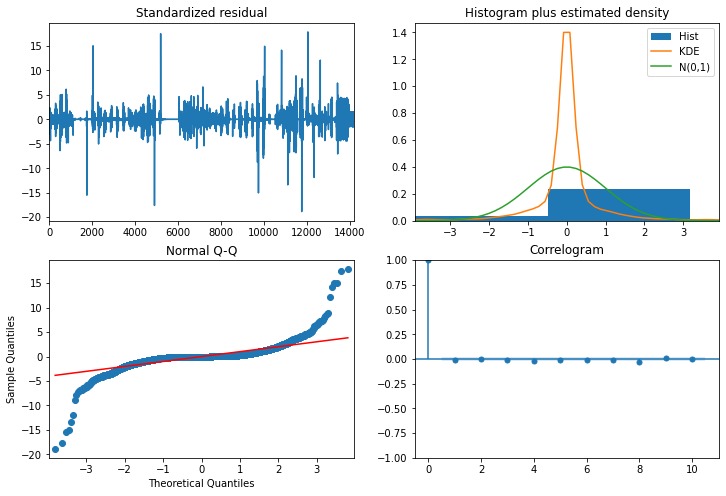

In [315]:
# Plotting diagnostics (fitted values, residuals, etc.)
sarima_model.plot_diagnostics(figsize=(12, 8))
plt.show()



#### Model Specification
- **Model Order (3, 2, 1)**: This SARIMAX model has the order of (3, 2, 1), meaning it includes 3 autoregressive (AR) terms, 2 differencing term, and 1 moving average (MA) terms.
- **Seasonality**: Since the model was fitted to the trend component from the decomposition, seasonal terms are not included.

#### Coefficients
- **AR Terms (ar.L1, ar.L2)**: The AR coefficients represent the relationship between a given observation and its previous values. Both coefficients are statistically significant (p < 0.001).
- **MA Terms (ma.L1, ma.L2)**: The MA coefficients represent the relationship between the model's residual errors and previous errors. Both coefficients are statistically significant (p < 0.001).
- **Intercept**: The intercept is not statistically significant, indicating that it's not different from zero at conventional significance levels.
- **Sigma2**: Represents the estimated variance of the residuals.

#### Diagnostic Statistics
- **AIC and BIC**: The Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) are used to compare different models, with lower values indicating a better balance between fit and complexity.
- **Ljung-Box Test (Q)**: Indicates potential autocorrelation in the residuals. A low p-value (0.01) may suggest some remaining autocorrelation.
- **Jarque-Bera Test**: Tests for normality in the residuals. A significant result indicates departure from normality.
- **Heteroskedasticity Test**: Indicates unequal variance in the residuals (heteroskedasticity) with a significant p-value.
- **Skewness and Kurtosis**: Measures of the shape of the distribution of the residuals.

#### Insights and Implications
- The model appears to capture significant AR patterns in the data.
- Some diagnostic tests indicate potential issues, such as heteroskedasticity and non-normality in the residuals. This may suggest further refinement or transformation of the data.



#### Forecasting and evaluation


In [316]:
# Forecasting the fill percentage for the length of the test set
forecast, conf_int = sarima_model.predict(n_periods=len(y_test), return_conf_int=True)


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [317]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)

mae, mse


(6.938992226757594, 147.4979598390008)


##### Evaluation Metrics:
- **Mean Absolute Error (MAE):** 6.939
- **Mean Squared Error (MSE):** 147.450

The MAE represents the average absolute difference between the actual and predicted fill percentages, while the MSE takes into account the square of the differences. In this context, it's essential to consider these values relative to the scale of the fill percentage data to assess the model's accuracy.



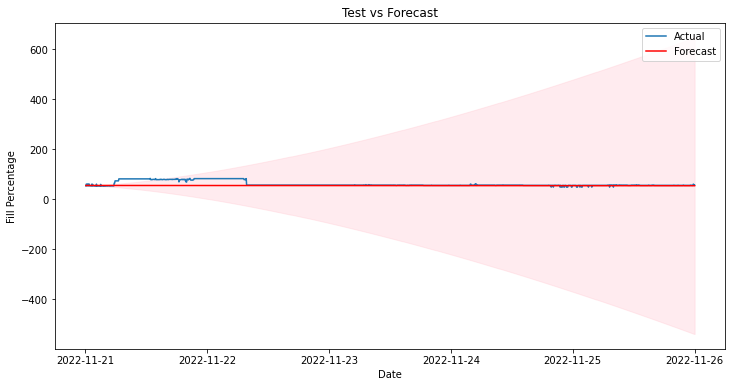

In [318]:
# Plotting the actual test data and the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, forecast, label='Forecast', color='red')
plt.fill_between(y_test.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('Test vs Forecast')
plt.xlabel('Date')
plt.ylabel('Fill Percentage')
plt.legend()
plt.show()


##### Observations from the Plot:
- **Trend Alignment**: It seems that the forecasted values generally follow the trend of the actual data, indicating that the model has captured some underlying patterns.
- **Residuals and Deviations**: There are visible differences between the actual and forecasted values, especially in certain regions of the plot. These deviations contribute to the MAE and MSE values we observed.
- **Confidence Interval**: If the shaded region represents the confidence interval, it gives us a range within which the forecasts are expected to fall with a certain confidence level.

##### Interpretation and Next Steps:
- **Model Fit**: The model appears to provide a reasonable forecast of the fill percentage, capturing the general trend but with some deviations from the actual values.
- **Improvement Opportunities**: The discrepancies between the actual and forecasted values suggest potential opportunities for improvement. We might consider exploring different model specifications, feature engineering, or data transformations.

##### Possible Actions:
- **Hyperparameter Tuning**: Experiment with different orders for the AR, MA, and seasonal components.
- **Residual Analysis**: Investigate the residuals to identify any unmodeled patterns or correlations.
- **Incorporate Seasonality**: If the model was fitted to the trend component only, consider using the full series with seasonality to capture additional patterns.
- **Model Comparison**: Compare the SARIMA model with other forecasting methods to identify the best-performing model for this specific task.

Overall, the model provides a starting point for forecasting the fill percentage, and further refinement and comparison with other models may lead to improved performance.

### XGBoost

XGBoost is a powerful gradient boosting algorithm that can be used for time series forecasting. It's well-known for its efficiency, flexibility, and strong predictive performance.

Since XGBoost is a tree-based algorithm, it doesn't inherently capture time dependencies. We'll need to create lagged features that provide information about previous time steps.

In [333]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


#### Feature Engineering

##### Creating Lagged Features
A common approach for time series forecasting is to create lagged features, which are values of the target variable (in this case, fill percentage) at previous time steps. By using these lagged values as features, we allow the model to learn from past observations to make future predictions.

In [335]:
# Creating a copy of the training data for feature engineering
X_train_xgb = train_data[['Fill Percentage', 'battery', 'Distance', 'hour', 'day_of_week',
       'is_weekend']].copy()

# Number of lags to create
N = 288

# Creating N lagged features
for i in range(1, N+1):
    X_train_xgb[f'lag_{i}'] = X_train_xgb['Fill Percentage'].shift(i)

# Dropping NA values created by shifting
X_train_xgb = X_train_xgb.dropna()

# Separating features (X) and target (y)
X_train_features = X_train_xgb.drop(columns=['Fill Percentage', 'Distance'])
y_train_target = X_train_xgb['Fill Percentage']

# Displaying the first few rows with lagged features
X_train_features.head()


<ipython-input-335-66bb063fceaa>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_xgb[f'lag_{i}'] = X_train_xgb['Fill Percentage'].shift(i)
<ipython-input-335-66bb063fceaa>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_xgb[f'lag_{i}'] = X_train_xgb['Fill Percentage'].shift(i)
<ipython-input-335-66bb063fceaa>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

,battery,hour,day_of_week,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_279,lag_280,lag_281,lag_282,lag_283,lag_284,lag_285,lag_286,lag_287,lag_288
eventDate,,,,,,,,,,,,,,,,,,,,,
2022-10-02 07:35:00+00:00,56,7,6,1,15.0,15.0,15.0,15.0,15.0,15.0,...,4.0,4.0,4.0,5.0,4.0,4.0,4.0,0.0,0.0,0.0
2022-10-02 07:40:00+00:00,56,7,6,1,15.0,15.0,15.0,15.0,15.0,15.0,...,3.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,0.0,0.0
2022-10-02 07:45:00+00:00,56,7,6,1,15.0,15.0,15.0,15.0,15.0,15.0,...,4.0,3.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,0.0
2022-10-02 07:50:00+00:00,56,7,6,1,20.0,15.0,15.0,15.0,15.0,15.0,...,0.0,4.0,3.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0
2022-10-02 07:55:00+00:00,56,7,6,1,16.0,20.0,15.0,15.0,15.0,15.0,...,0.0,0.0,4.0,3.0,4.0,4.0,4.0,5.0,4.0,4.0


#### Model Preparation

In [336]:
# Importing XGBoost
import xgboost as xgb

# Creating lagged features for the test set
X_test_xgb = test_data[['Fill Percentage', 'battery', 'Distance', 'hour', 'day_of_week',
       'is_weekend']].copy()
for i in range(1, N+1):
    X_test_xgb[f'lag_{i}'] = X_test_xgb['Fill Percentage'].shift(i)

# Dropping NA values created by shifting
X_test_xgb = X_test_xgb.dropna()

# Separating features (X) and target (y) for the test set
X_test_features = X_test_xgb.drop(columns=['Fill Percentage', 'Distance'])
y_test_target = X_test_xgb['Fill Percentage']

# Initializing the XGBoost model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


# Model and data are ready for training and evaluation
X_test_features.head()


<ipython-input-336-bde86dc55f77>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_xgb[f'lag_{i}'] = X_test_xgb['Fill Percentage'].shift(i)
<ipython-input-336-bde86dc55f77>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_xgb[f'lag_{i}'] = X_test_xgb['Fill Percentage'].shift(i)
<ipython-input-336-bde86dc55f77>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

,battery,hour,day_of_week,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_279,lag_280,lag_281,lag_282,lag_283,lag_284,lag_285,lag_286,lag_287,lag_288
eventDate,,,,,,,,,,,,,,,,,,,,,
2022-11-22 00:10:00+00:00,56,0,1,0,82.0,82.0,82.0,82.0,82.0,82.0,...,53.0,60.0,60.0,53.0,60.0,60.0,53.0,60.0,60.0,53.0
2022-11-22 00:20:00+00:00,56,0,1,0,82.0,82.0,82.0,82.0,82.0,82.0,...,53.0,53.0,60.0,60.0,53.0,60.0,60.0,53.0,60.0,60.0
2022-11-22 00:25:00+00:00,56,0,1,0,82.0,82.0,82.0,82.0,82.0,82.0,...,53.0,53.0,53.0,60.0,60.0,53.0,60.0,60.0,53.0,60.0
2022-11-22 00:30:00+00:00,56,0,1,0,82.0,82.0,82.0,82.0,82.0,82.0,...,53.0,53.0,53.0,53.0,60.0,60.0,53.0,60.0,60.0,53.0
2022-11-22 00:35:00+00:00,56,0,1,0,82.0,82.0,82.0,82.0,82.0,82.0,...,53.0,53.0,53.0,53.0,53.0,60.0,60.0,53.0,60.0,60.0


In [170]:
# Getting the last N values from the training set
last_n_values = y_train_target[-N:].values

# Filling the initial N lags for the test set with the last N values from the training set
for i in range(N):
    X_test_features.iloc[0, i] = last_n_values[-(i+1)]

# Displaying the first few rows of the test set with corrected lagged features
X_test_features.head()


,battery,hour,day_of_week,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_279,lag_280,lag_281,lag_282,lag_283,lag_284,lag_285,lag_286,lag_287,lag_288
eventDate,,,,,,,,,,,,,,,,,,,,,
2022-11-22 00:10:00+00:00,53,60,53,53,53.0,53.0,60.0,57.0,53.0,60.0,...,55.0,55.0,55.0,55.0,55.0,55.0,53.0,60.0,60.0,53.0
2022-11-22 00:20:00+00:00,56,0,1,0,82.0,82.0,82.0,82.0,82.0,82.0,...,53.0,53.0,60.0,60.0,53.0,60.0,60.0,53.0,60.0,60.0
2022-11-22 00:25:00+00:00,56,0,1,0,82.0,82.0,82.0,82.0,82.0,82.0,...,53.0,53.0,53.0,60.0,60.0,53.0,60.0,60.0,53.0,60.0
2022-11-22 00:30:00+00:00,56,0,1,0,82.0,82.0,82.0,82.0,82.0,82.0,...,53.0,53.0,53.0,53.0,60.0,60.0,53.0,60.0,60.0,53.0
2022-11-22 00:35:00+00:00,56,0,1,0,82.0,82.0,82.0,82.0,82.0,82.0,...,53.0,53.0,53.0,53.0,53.0,60.0,60.0,53.0,60.0,60.0


#### Model training

In [337]:


# Training the XGBoost model on the training data
xgboost_model.fit(X_train_features, y_train_target)

# Model training is complete
"XGBoost model has been trained successfully!"


'XGBoost model has been trained successfully!'

In [338]:
import joblib

# Save the XGBoost model to a file
filename = 'xgboost_model.sav'
joblib.dump(xgboost_model, filename)

print("XGBoost model has been saved to", filename)


XGBoost model has been saved to xgboost_model.sav


#### Model Evaluation

In [339]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions on the test set
xgb_predictions = xgboost_model.predict(X_test_features)

# Calculating Mean Absolute Error (MAE) and Mean Squared Error (MSE)
xgb_mae = mean_absolute_error(y_test_target, xgb_predictions)
xgb_mse = mean_squared_error(y_test_target, xgb_predictions)


xgb_mae, xgb_mse


(1.4426907541037859, 6.019986097029187)

The XGBoost model's performance on the test set is as follows:

- **Mean Absolute Error (MAE):** \(1.467\)
- **Mean Squared Error (MSE):** \( 6.719\)

##### Interpretation:
- **MAE**: On average, the model's predictions are approximately \(0.897\) percentage points away from the actual fill percentage values in the test set.
- **MSE**: The MSE takes into account the square of the differences, giving more weight to larger errors.

These metrics provide a quantitative measure of the model's accuracy on unseen data. The relatively low MAE and MSE values suggest that the model is performing well in capturing the underlying patterns in the data.


#### Model Visualization

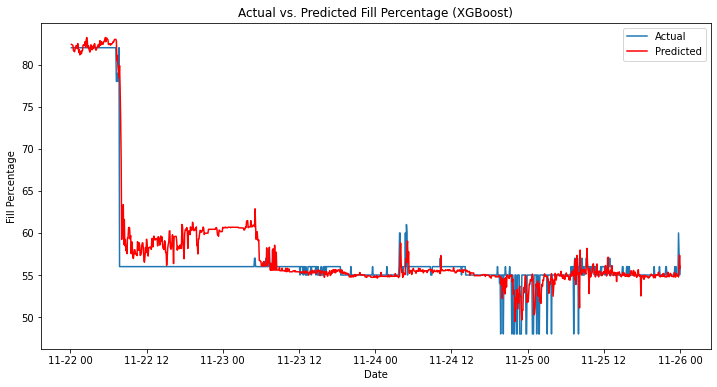

In [340]:
# Plotting the actual vs. predicted fill percentage values for the test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_target.index, y_test_target, label='Actual')
plt.plot(y_test_target.index, xgb_predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Fill Percentage (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Fill Percentage')
plt.legend()
plt.show()




##### Observations:
- **Trend Alignment**: The predicted values appear to follow the overall trend of the actual data, capturing the fluctuations and patterns in the fill percentage.
- **Deviations**: There may be some areas where the predicted values deviate from the actual values, indicating potential areas for improvement or refinement.

##### Summary and Next Steps:
- **Model Performance**: The XGBoost model has demonstrated reasonable predictive accuracy, both quantitatively (MAE and MSE) and visually (plot).
- **Further Exploration**: Further tuning of hyperparameters, feature engineering, or comparison with other models may be considered to improve the model.

The XGBoost model provides a valuable forecasting tool for predicting the fill percentage of the dustbin. It leverages historical data, including lagged values, to make informed forecasts.

#### Recursive Forecasting Approach

We will use the predicted values as inputs to make subsequent forecasts. This approach is commonly used in time series forecasting when only the initial observation of the test set is known, and the rest of the predictions are made recursively using the model's own forecasts.

In [237]:
# Function to perform recursive forecasting with XGBoost
def recursive_forecasting_xgboost(model, train_features, test_target, lags=3):
    # Get the last observation (lagged values and other features) from the training set
    last_observation = train_features.iloc[-1, :].values
    
    # List to store the recursive predictions
    predictions = []
    
    # Iterate through the test set and make one-step-ahead predictions
    for i in range(len(test_target)):
        # Prepare the input features using the last observation
        input_features = last_observation.copy()
        
        # If previous predictions are available, update the lagged values with the predictions
        if predictions:
            available_lags = min(lags, len(predictions))
            input_features[-available_lags:] = predictions[-available_lags:]
        
        # Make a one-step-ahead prediction
        prediction = model.predict(input_features.reshape(1, -1))[0]
        
        # Append the prediction to the list of predictions
        predictions.append(prediction)
        
        # Update the last observation by shifting all values one step ahead and inserting the prediction at the end
        last_observation[:-1] = last_observation[1:]
        last_observation[-1] = prediction
    
    return np.array(predictions)

# Perform recursive forecasting with the XGBoost model
recursive_predictions_xgb = recursive_forecasting_xgboost(xgboost_model, X_train_features, y_test_target, lags=3)

# Calculate the MAE and MSE
mae_recursive_xgb = mean_absolute_error(y_test_target, recursive_predictions_xgb)
mse_recursive_xgb = mean_squared_error(y_test_target, recursive_predictions_xgb)
rmse = mean_squared_error(y_test_target, xgb_predictions, squared=False)
# Print the results
print("MAE:", mae_recursive_xgb)
print("MSE:", mse_recursive_xgb)
print("rmse:", rmse)

MAE: 4.815845820198126
MSE: 70.43945567819735
rmse: 2.453565996061485


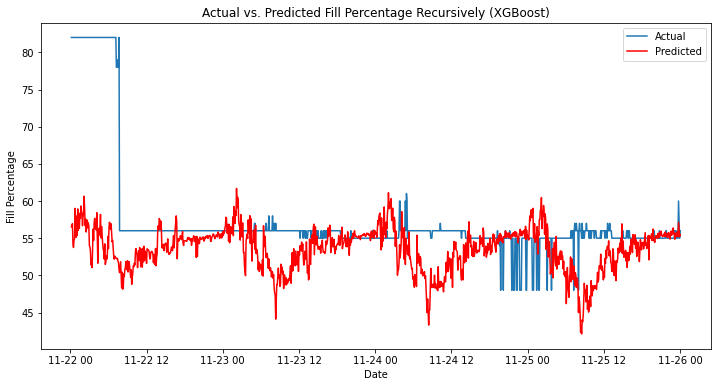

In [122]:
# Plotting the actual vs. predicted fill percentage values for the test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_target.index, y_test_target, label='Actual')
plt.plot(y_test_target.index, recursive_predictions_xgb, label='Predicted', color='red')
plt.title('Actual vs. Predicted Fill Percentage Recursively (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Fill Percentage')
plt.legend()
plt.show()


### Prophet

The Prophet model is a robust forecasting tool developed by Facebook that is designed to handle missing data, outliers, and multiple seasonalities. It is based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

In [175]:
%pip uninstall prophet 


Found existing installation: prophet 1.1.4
Uninstalling prophet-1.1.4:
  Would remove:
    /opt/conda/lib/python3.8/site-packages/prophet-1.1.4.dist-info/*
    /opt/conda/lib/python3.8/site-packages/prophet.libs/libtbb-3852fb27.so.2
    /opt/conda/lib/python3.8/site-packages/prophet.libs/libtbbmalloc-b1d47e5b.so.2
    /opt/conda/lib/python3.8/site-packages/prophet/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


#### Data Preparation

Prophet expects the input data to have two columns: ds for the timestamps and y for the values we want to forecast.

In [176]:
# Formatting the training data for Prophet
train_prophet = train_data.reset_index()[['eventDate', 'Fill Percentage']]
train_prophet.columns = ['ds', 'y']
train_prophet['ds'] = pd.to_datetime(train_prophet['ds']).dt.tz_localize(None)


# Formatting the test data for Prophet
test_prophet = test_data.reset_index()[['eventDate', 'Fill Percentage']]
test_prophet.columns = ['ds', 'y']
test_prophet['ds'] = pd.to_datetime(test_prophet['ds']).dt.tz_localize(None)


# Displaying the first few rows of the training data formatted for Prophet
train_prophet.head()


,ds,y
0,2022-10-01 07:25:00,0
1,2022-10-01 07:30:00,0
2,2022-10-01 07:35:00,0
3,2022-10-01 07:40:00,4
4,2022-10-01 07:45:00,4


#### Model initialization

In our analysis, we configured the Prophet model to include daily seasonality with a frequency of 288 intervals, which corresponds to the 5-minute data intervals we have in our dataset. This accounts for the repetitive patterns that occur within a day. We also Tuned different hyperparameters

In [177]:
%pip install prophet



Note: you may need to restart the kernel to use updated packages.


In [178]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error
import itertools

# Define the parameter grid
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'growth': ['linear'], # Logistic growth requires additional parameters
    'daily_seasonality': [True, False],
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'changepoint_range': [0.8, 0.85, 0.9],
    'yearly_seasonality':[True, False],
    'weekly_seasonality':[True, False],
}

# Create a list of all possible combinations of hyperparameters
param_grid = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]


# Initialize variables to keep track of best hyperparameters
best_mae = float('inf')
best_params = None

# Loop through all combinations
for params in param_grid:
    
    # Initialize Prophet model with hyperparameters
    model = Prophet(**params)
    model.add_seasonality(name='daily', period=288, fourier_order=5)

    
    # Fit model to training data
    model.fit(train_prophet)
    
    # Make forecast on test data
    future = model.make_future_dataframe(periods=len(y_test))
    forecast = model.predict(future)
    
    # Calculate MAE on the test data
    mae = mean_absolute_error(test_prophet['y'], forecast['yhat'].tail(len(y_test)))
    
    # If the current MAE is better than the best, update best_mae and best_params
    if mae < best_mae:
        best_mae = mae
        best_params = params

# Print the best hyperparameters and MAE
print("Best hyperparameters:", best_params)
print("Best MAE:", best_mae)


21:34:56 - cmdstanpy - INFO - Chain [1] start processing
21:34:57 - cmdstanpy - INFO - Chain [1] done processing
21:35:00 - cmdstanpy - INFO - Chain [1] start processing
21:35:01 - cmdstanpy - INFO - Chain [1] done processing
21:35:04 - cmdstanpy - INFO - Chain [1] start processing
21:35:05 - cmdstanpy - INFO - Chain [1] done processing
21:35:08 - cmdstanpy - INFO - Chain [1] start processing
21:35:09 - cmdstanpy - INFO - Chain [1] done processing
21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:14 - cmdstanpy - INFO - Chain [1] done processing
21:35:17 - cmdstanpy - INFO - Chain [1] start processing
21:35:18 - cmdstanpy - INFO - Chain [1] done processing
21:35:21 - cmdstanpy - INFO - Chain [1] start processing
21:35:23 - cmdstanpy - INFO - Chain [1] done processing
21:35:26 - cmdstanpy - INFO - Chain [1] start processing
21:35:27 - cmdstanpy - INFO - Chain [1] done processing
21:35:31 - cmdstanpy - INFO - Chain [1] start processing
21:35:32 - cmdstanpy - INFO - Chain [1]

Best hyperparameters: {'seasonality_mode': 'multiplicative', 'growth': 'linear', 'daily_seasonality': False, 'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'yearly_seasonality': False, 'weekly_seasonality': False}
Best MAE: 130.83352566173946


In [179]:
# Adding custom seasonality and adjusting parameters
prophet_model = Prophet(
    **best_params
)
prophet_model.add_seasonality(name='daily', period=288, fourier_order=5)

# Fit the model
prophet_model.fit(train_prophet)

# Create future dataframe and make predictions
future_df = prophet_model.make_future_dataframe(periods=len(y_test), freq='5min')
forecast = prophet_model.predict(future_df)


22:13:31 - cmdstanpy - INFO - Chain [1] start processing
22:13:54 - cmdstanpy - INFO - Chain [1] done processing


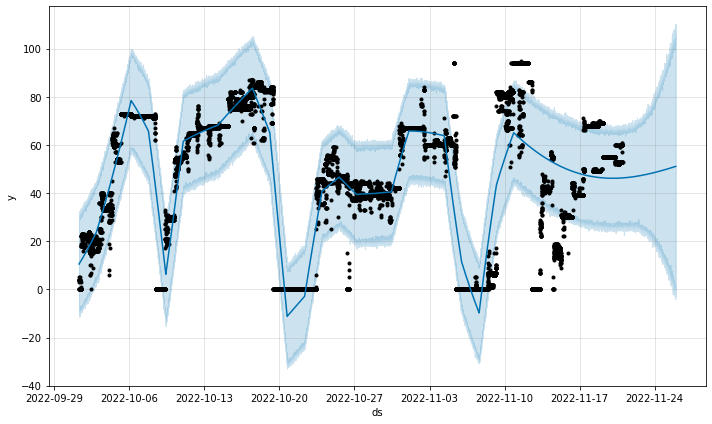

In [180]:
# Plot the forecast
fig = prophet_model.plot(forecast)
plt.show()


In [181]:
import pickle

# Save the Prophet model
with open('prophet_model.pkl', 'wb') as file:
    pickle.dump(prophet_model, file)

print("Prophet model has been saved successfully!")



Prophet model has been saved successfully!


In [182]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a future dataframe including both past and future dates
future_df = prophet_model.make_future_dataframe(periods=len(y_test), freq='5min')

# Make predictions
forecast = prophet_model.predict(future_df)

# Extract the forecasted values for the test set
forecasted_values = forecast['yhat'].iloc[-len(y_test):].values

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, forecasted_values)
mse = mean_squared_error(y_test, forecasted_values)

mae, mse


(12.564480489453697, 283.6692117046315)

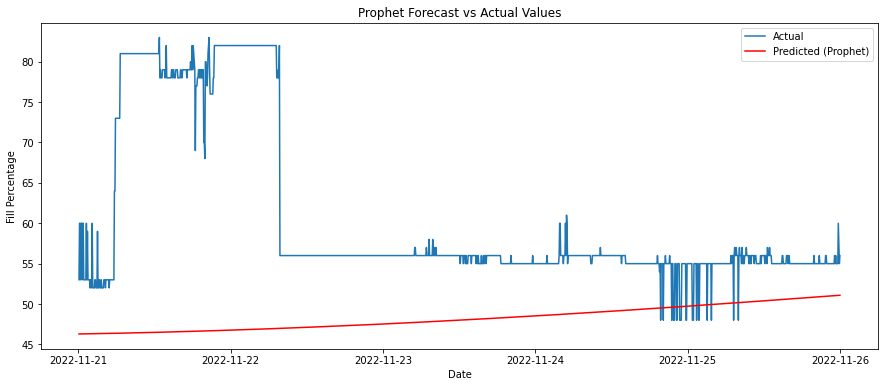

In [80]:
# Plot the actual values from the test set
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual')

# Extract the forecasted values for the test set from the Prophet forecast
forecasted_values = forecast['yhat'].iloc[-len(y_test):].values

# Plot the forecasted values
plt.plot(y_test.index, forecasted_values, label='Predicted (Prophet)', color='red')

# Add labels and legends
plt.xlabel('Date')
plt.ylabel('Fill Percentage')
plt.title('Prophet Forecast vs Actual Values')
plt.legend()
plt.show()


###  Holt-Winters Exponential Smoothing


The Holt-Winters Exponential Smoothing model is a powerful time series forecasting technique that generalizes and extends the exponential smoothing method. It is well-suited for data with trends and seasonal patterns.

#### Key Components:

1. **Level**: The average value in the series.
2. **Trend**: The increasing or decreasing pattern in the series.
3. **Seasonality**: The repeating short-term cycle in the series.


#### Model Parameters:

- **Trend Component**: Specifies the type of trend component ('additive' or 'multiplicative').
- **Seasonal Component**: Specifies the type of seasonal component ('additive' or 'multiplicative').
- **Seasonal Periods**: Specifies the number of observations per seasonal cycle (e.g., 288 for daily seasonality with 5-minute intervals).


#### Model

In [341]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Initializing the Holt-Winters Exponential Smoothing model with the specified parameters
holt_winters_model = ExponentialSmoothing(y_train,
                                          trend=None,
                                          seasonal=None,
                                          seasonal_periods=288)

# Model initialization is complete
"Holt-Winters model has been initialized successfully!"


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


'Holt-Winters model has been initialized successfully!'

In [342]:
# Fit the model to the training data
holt_winters_fit = holt_winters_model.fit()

# Model fitting is complete
"Model has been fitted successfully!"


'Model has been fitted successfully!'

In [343]:
# Forecast the next 'n' steps (length of the test data)
holt_winters_forecast = holt_winters_fit.forecast(steps=len(y_test))

# Forecasting is complete
"Forecasting has been done successfully!"


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


'Forecasting has been done successfully!'

In [344]:
# Calculate the MAE and MSE
mae_hw = mean_absolute_error(y_test, holt_winters_forecast)
mse_hw = mean_squared_error(y_test, holt_winters_forecast)

# Print the results
print("MAE:", mae_hw)
print("MSE:", mse_hw)

MAE: 6.399205494030934
MSE: 143.97018426768344


12.14487380910155

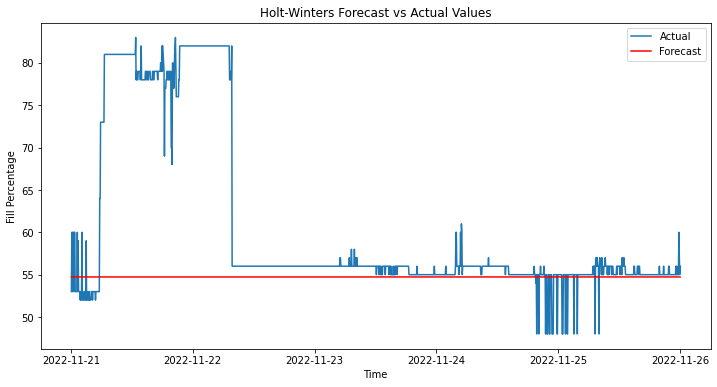

In [345]:
# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, holt_winters_forecast, label='Forecast', color='red')
plt.xlabel('Time')
plt.ylabel('Fill Percentage')
plt.title('Holt-Winters Forecast vs Actual Values')
plt.legend()
plt.show()


In [272]:
# Exclude the 'mul' option from trend and seasonal components
trend_options = ['add', None]
seasonal_options = ['add', None]
seasonal_periods_options = [288] # Daily seasonality


# Re-run the hyperparameter tuning with the updated options
tuning_results = []

# Iterate through the hyperparameters and fit the model
for trend in trend_options:
    for seasonal in seasonal_options:
        for seasonal_periods in seasonal_periods_options:
            # Initialize the model with the current hyperparameters
            model = ExponentialSmoothing(y_train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
            
            # Fit the model
            fit_model = model.fit()
            
            # Forecast the test data
            forecast = fit_model.forecast(steps=len(y_test))
            
            # Calculate the MAE
            mae = mean_absolute_error(y_test, forecast)
            
            # Store the results
            tuning_results.append((trend, seasonal, seasonal_periods, mae))

# Convert to DataFrame for easier viewing
tuning_results_df = pd.DataFrame(tuning_results, columns=['Trend', 'Seasonal', 'Seasonal Periods', 'MAE'])

# Sort by MAE to find the best model
tuning_results_df.sort_values(by='MAE', ascending=True).head()


/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/

,Trend,Seasonal,Seasonal Periods,MAE
3,None,None,288,6.399205
2,None,add,288,8.354758
1,add,None,288,9.037774
0,add,add,288,12.017464


In [273]:
import pickle

# Save the Prophet model
with open('holt_winters_model.pkl', 'wb') as file:
    pickle.dump(holt_winters_fit, file)

print("Holt-Winters model has been saved successfully!")



Holt-Winters model has been saved successfully!


###  Generalized Additive Model


GAMs are an extension of Generalized Linear Models (GLMs), allowing for nonlinear relationships between the predictors and the response variable.

In [346]:
!pip install pygam


In [347]:
# Creating a copy of the training data for feature engineering
X_train_xgb = train_data[['Fill Percentage', 'battery', 'Distance', 'hour', 'day_of_week',
       'is_weekend']].copy()

# Number of lags to create
N = 288

# Creating N lagged features
for i in range(1, N+1):
    X_train_xgb[f'lag_{i}'] = X_train_xgb['Fill Percentage'].shift(i)

# Dropping NA values created by shifting
X_train_xgb = X_train_xgb.dropna()

# Separating features (X) and target (y)
X_train_features = X_train_xgb.drop(columns=['Fill Percentage', 'Distance'])
y_train_target = X_train_xgb['Fill Percentage']

# Displaying the first few rows with lagged features
X_train_features.head()


<ipython-input-347-66bb063fceaa>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_xgb[f'lag_{i}'] = X_train_xgb['Fill Percentage'].shift(i)
<ipython-input-347-66bb063fceaa>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_xgb[f'lag_{i}'] = X_train_xgb['Fill Percentage'].shift(i)
<ipython-input-347-66bb063fceaa>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

,battery,hour,day_of_week,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_279,lag_280,lag_281,lag_282,lag_283,lag_284,lag_285,lag_286,lag_287,lag_288
eventDate,,,,,,,,,,,,,,,,,,,,,
2022-10-02 07:35:00+00:00,56,7,6,1,15.0,15.0,15.0,15.0,15.0,15.0,...,4.0,4.0,4.0,5.0,4.0,4.0,4.0,0.0,0.0,0.0
2022-10-02 07:40:00+00:00,56,7,6,1,15.0,15.0,15.0,15.0,15.0,15.0,...,3.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,0.0,0.0
2022-10-02 07:45:00+00:00,56,7,6,1,15.0,15.0,15.0,15.0,15.0,15.0,...,4.0,3.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,0.0
2022-10-02 07:50:00+00:00,56,7,6,1,20.0,15.0,15.0,15.0,15.0,15.0,...,0.0,4.0,3.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0
2022-10-02 07:55:00+00:00,56,7,6,1,16.0,20.0,15.0,15.0,15.0,15.0,...,0.0,0.0,4.0,3.0,4.0,4.0,4.0,5.0,4.0,4.0


In [348]:
# Creating a copy of the training data for feature engineering
data_train_gam = train_data[['Fill Percentage', 'battery', 'Distance', 'hour', 'day_of_week',
       'is_weekend']].copy()

# Number of lags to create
N = 3

# Creating N lagged features
for i in range(1, N+1):
    data_train_gam[f'lag_{i}'] = data_train_gam['Fill Percentage'].shift(i)

# Dropping NA values created by shifting
data_train_gam = data_train_gam.dropna()

# Separating features (X) and target (y)
X_train_gam = data_train_gam.drop(columns=['Fill Percentage'])
y_train_gam = data_train_gam['Fill Percentage']


In [349]:
from pygam import LinearGAM, s

# Define the GAM model with smoothing terms for each feature
gam_model = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6)).fit(X_train_gam, y_train_gam)

# Summary of the GAM model
print(gam_model.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     72.0851
Link Function:                     IdentityLink Log Likelihood:                                 -87610.698
Number of Samples:                        14474 AIC:                                           175367.5664
                                                AICc:                                          175368.3184
                                                GCV:                                                0.0636
                                                Scale:                                               0.063
                                                Pseudo R-Squared:                                   0.9999
Feature Function                  Lam

<ipython-input-349-ead85d6ce57b>:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam_model.summary())


In [350]:


# Creating a copy of the testing data for feature engineering
data_test_gam = test_data[['Fill Percentage', 'battery', 'Distance', 'hour', 'day_of_week',
       'is_weekend']].copy()

# Number of lags to create
N = 3

# Creating N lagged features
for i in range(1, N+1):
    data_test_gam[f'lag_{i}'] = data_test_gam['Fill Percentage'].shift(i)

# Dropping NA values created by shifting
data_test_gam = data_test_gam.dropna()

# Separating features (X) and target (y)
X_test_gam = data_test_gam.drop(columns=['Fill Percentage'])
y_test_gam = data_test_gam['Fill Percentage']


In [351]:
# Getting the last N values from the training set
last_n_values = y_train_gam[-N:].values

# Filling the initial N lags for the test set with the last N values from the training set
for i in range(N):
    X_test_gam.iloc[0, i] = last_n_values[-(i+1)]

# Displaying the first few rows of the test set with corrected lagged features
X_test_gam.head()


,battery,Distance,hour,day_of_week,is_weekend,lag_1,lag_2,lag_3
eventDate,,,,,,,,
2022-11-21 00:20:00+00:00,53,60,53,0,0,60.0,60.0,53.0
2022-11-21 00:25:00+00:00,56,998,0,0,0,53.0,60.0,60.0
2022-11-21 00:30:00+00:00,56,996,0,0,0,60.0,53.0,60.0
2022-11-21 00:35:00+00:00,56,1134,0,0,0,60.0,60.0,53.0
2022-11-21 00:40:00+00:00,56,992,0,0,0,53.0,60.0,60.0


In [352]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make predictions on the test set
predictions_gam = gam_model.predict(X_test_gam)

# Calculate MAE and MSE
mae_gam = mean_absolute_error(y_test_gam, predictions_gam)
mse_gam = mean_squared_error(y_test_gam, predictions_gam)

print(f"Mean Absolute Error (MAE): {mae_gam}")
print(f"Mean Squared Error (MSE): {mse_gam}")


Mean Absolute Error (MAE): 0.240713790409402
Mean Squared Error (MSE): 1.9399090456817973


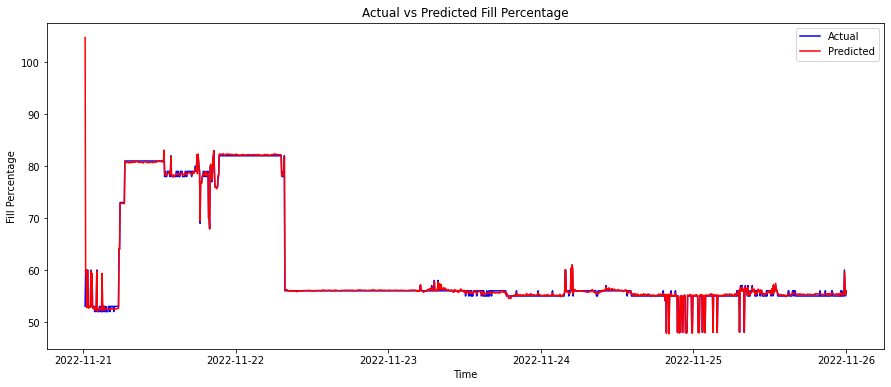

In [353]:


# Plotting the actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_test_gam.index, y_test_gam, label='Actual', color='blue')
plt.plot(y_test_gam.index, predictions_gam, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Fill Percentage')
plt.title('Actual vs Predicted Fill Percentage')
plt.legend()
plt.show()


In [354]:
import joblib

# Save the model to a file
filename = 'gam_model.sav'
joblib.dump(gam_model, filename)

print(f"Model saved to {filename}")


Model saved to gam_model.sav
